<a href="https://colab.research.google.com/github/Elhai12/SBA_loans_predict/blob/main/Feature_Engineering_%26_Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Clone git to get the files
!git clone https://github.com/Elhai12/SBA_loans_predict.git

Cloning into 'SBA_loans_predict'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 126 (delta 64), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (126/126), 19.19 MiB | 5.61 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
warnings.filterwarnings('ignore')

import time
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.subplots as sp
from scipy.stats import mannwhitneyu,chisquare,chi2_contingency
import plotly.express as px
from SBA_loans_predict import Functions_for_EDA
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from geopy.geocoders import Nominatim
from folium import plugins
import folium
from wordcloud import WordCloud
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb

In [3]:
df = pd.read_pickle('/content/SBA_loans_predict/manipulated_data.pkl')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41212 entries, 0 to 41211
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   ApprovalFY         41212 non-null  float64 
 1   Term               41212 non-null  float64 
 2   NoEmp              41212 non-null  float64 
 3   CreateJob          41212 non-null  float64 
 4   RetainedJob        41212 non-null  float64 
 5   DisbursementGross  41212 non-null  float64 
 6   GrAppv             41212 non-null  float64 
 7   SBA_Appv           41212 non-null  float64 
 8   Month_apv          41212 non-null  float64 
 9   Day_apv            41212 non-null  float64 
 10  Diff_days          41212 non-null  float64 
 11  FEDFUNDS           41212 non-null  float64 
 12  change_rate_fed    41212 non-null  float64 
 13  UrbanRural         41212 non-null  category
 14  RevLineCr          41212 non-null  category
 15  LowDoc             41212 non-null  category
 16  MIS_

#Feature Engineer

In [5]:
#Get the Zipcode and create intercative map
df_code = pd.read_pickle('/content/SBA_loans_predict/text_zip.pkl')

# def get_coordinates_from_nominatim(postal_code):
#     geolocator = Nominatim(user_agent="Nominatim")
#     location = geolocator.geocode({"postalcode": postal_code},country_codes='Florida',language="en",timeout=5)

#     if location:
#       if 'Florida' in location.address:
#         print(f"Coordinates found for postal code: {postal_code}")
#         return location.longitude, location.latitude
#       else:
#         print(f"Coordinates not found for postal code: {postal_code}")
#         return None, None

#     else:
#       print(f"Coordinates not found for postal code: {postal_code}")
#       return None, None

# coordinates_dict = {}
# i = 1
# for postal_code in df_code['Zip'].unique().tolist():
#     print(i)
#     Longitude, Latitude = get_coordinates_from_nominatim(postal_code)
#     coordinates_dict[postal_code] = [Latitude, Longitude]
#     i+=1
# coordinates_dict

In [6]:
# df_coordinates = pd.DataFrame.from_dict(
#     coordinates_dict,
#     orient='index',
#     columns=['Longitude','Latitude']
# )
# df_coordinates.reset_index(inplace=True)
# df_coordinates.rename(columns={'index': 'Postal_Code'}, inplace=True)
# df_coordinates.to_csv("codes_coordinates.csv",index=False)


In [7]:
df_coordinates = pd.read_csv('/content/SBA_loans_predict/codes_coordinates.csv')
df_coordinates

,Postal_Code,Latitude,Longitude
0,32801,-81.376370,28.542968
1,34491,NaN,NaN
2,32456,-85.367452,29.884669
3,33065,-80.256887,26.268428
4,33186,-80.407726,25.659221
...,...,...,...
1357,32199,NaN,NaN
1358,33939,NaN,NaN
1359,94607,NaN,NaN
1360,33932,NaN,NaN


In [8]:
df_coordinates = df_coordinates.dropna()

In [9]:
df_coordinates = df_coordinates.dropna()
df_merge = pd.merge(df_coordinates,df_code,left_on='Postal_Code',right_on='Zip',how='inner')
#Get the loans status
df_coordinates_merge = df_merge[['Postal_Code','Latitude','Longitude','MIS_Status']]
#Aggregate for ceach erea how much paid and how much CHGOFF
df_agg = df_coordinates_merge.groupby(['Postal_Code','Latitude','Longitude'])['MIS_Status'].value_counts().unstack().fillna(0).reset_index()
df_agg.columns = ['Postal_Code','Latitude','Longitude','CHGOFF','PayFull']

#Get the percent of CHGOFF, gropping for over/under 50%, add total
df_agg['prc_CHGOFF'] = round(df_agg['CHGOFF']/(df_agg['CHGOFF']+df_agg['PayFull']),3)
df_agg['Over_50'] = np.where(df_agg['prc_CHGOFF']>=0.5,"Over_50_percent","Under_50_percent")
df_agg['Total'] = df_agg['CHGOFF']+df_agg['PayFull']

fig = px.scatter_mapbox(
    df_agg,
    lat="Longitude",
    lon="Latitude",
    hover_name="Postal_Code",
    hover_data={
        "Latitude": False,
        "Longitude": False,
        "Postal_Code": False,
        "CHGOFF": True,
        "PayFull": True,
    },

    size= 'Total',
    color= 'Over_50'

)
# Customize map layout
fig.update_traces(marker=dict(sizeref=1, sizemin=5))
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_center={"lat": df_agg['Longitude'].mean(), "lon": df_agg['Latitude'].mean()},
    mapbox_zoom=5,
    title="Zip Code Map"
)
fig.show()

In [10]:
#Get the names of the companies and use text analsys for most word for each group

df_name = df_code[['Name','MIS_Status']]

group_name_pay = df_name[df_name['MIS_Status']=='P I F']['Name']
group_name_chagoff = df_name[df_name['MIS_Status']=='CHGOFF']['Name']

text_pay= " ".join(group_name_pay).lower()
text_chagoff= " ".join(group_name_chagoff).lower()

#Function for remove words not relevant
def remove_special_characters(text,remove_words):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    words= clean_text.split()
    filtered_words = [word for word in words if word not in remove_words and len(word)>1]
    filtered_text = " ".join(filtered_words)

    return filtered_text

remove_words = ['inc','inn','llc','corporation','florida','service','international'
,'corp','group','usa','enterprise','enterprises','services','company','dba','center','co','associate','associates','system',
'systems','solution','solutions','american']

text_pay = remove_special_characters(text_pay,remove_words)
text_chagoff = remove_special_characters(text_chagoff,remove_words)

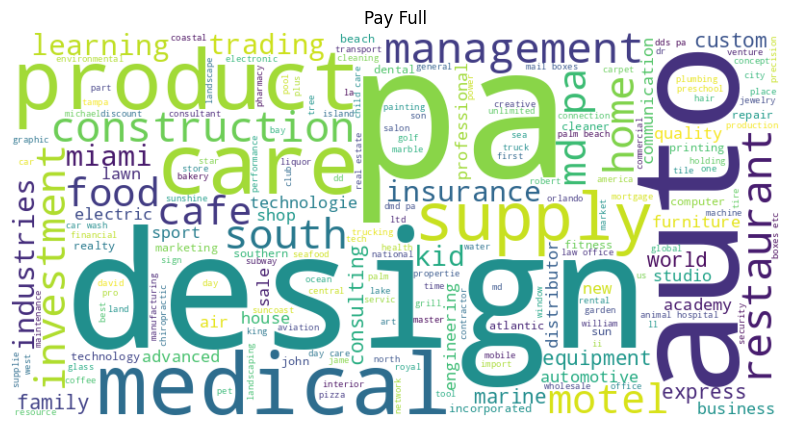

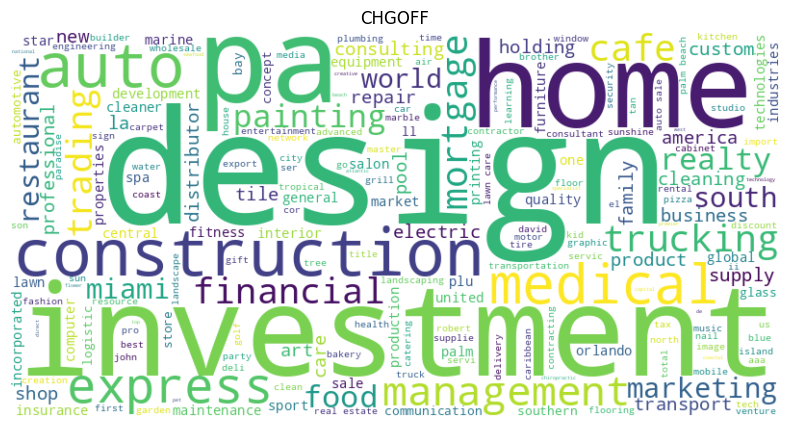

In [11]:
#Function create word cloud
def gen_word_cloud(text,title):
  wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='viridis').generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(title)
  plt.show()

gen_word_cloud(text_pay,'Pay Full')
gen_word_cloud(text_chagoff,'CHGOFF')

#Tests on the target group

In [12]:
#A T-test was conducted on the approved loan amounts to compare those who fully paid those who did not.
paid = df[df['MIS_Status'] == 1]['GrAppv']
unpaid = df[df['MIS_Status'] == 0]['GrAppv']
t_stat, p_value = ttest_ind(paid, unpaid)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 41.49915811547777
P-value: 0.0


In [13]:
#A Chi-Square test was conducted on the company sector to compare those who fully paid those who did not.
contingency_table = pd.crosstab( df['Sector_group'],df['MIS_Status'])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {round(p_value,5)}")

Chi-Square Statistic: 973.0567489128154
P-value: 0.0


#Feature selction

In [14]:
#Convert category to encoding for fit models and choose features
df_coding = df.copy()

cat_cols = df_coding.select_dtypes(exclude=np.number).columns.tolist()

encoder = LabelEncoder()
for col in cat_cols:
    df_coding[col] = encoder.fit_transform(df_coding[col])

In [15]:
#Define X and Y
X = df_coding.drop(['MIS_Status'], axis=1)
y = df_coding['MIS_Status']

In [16]:
# Fit models and determine if a feature is selected (1) or not (0)
lasso = Lasso(alpha=0.01).fit(X, y)
lasso_selected = (np.abs(lasso.coef_) > 0).astype(int)

# Fit Ridge model
ridge = Ridge(alpha=0.01).fit(X, y)
ridge_selected = (np.abs(ridge.coef_) > 0).astype(int)

svm = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
svm_selected = (np.abs(svm.coef_[0]) > 0).astype(int)

XGBoost = xgb.XGBClassifier().fit(X, y)
XGBoost_selected = (XGBoost.feature_importances_ > 0).astype(int)

rf = RandomForestClassifier().fit(X, y)
rf_selected = (rf.feature_importances_ > 0).astype(int)

# Create a DataFrame to store results
selection_df = pd.DataFrame({
    'Feature': X.columns,
    'Lasso': lasso_selected,
    'SVM': svm_selected,
    'XGBoost': XGBoost_selected,
    'RandomForest': rf_selected,
    'Ridge': ridge_selected
})

# Sum the number of selections for each feature
selection_df['Sum'] = selection_df[['Lasso', 'SVM', 'XGBoost', 'RandomForest','Ridge']].sum(axis=1)

# Output the results
print(selection_df)

              Feature  Lasso  SVM  XGBoost  RandomForest  Ridge  Sum
0          ApprovalFY      1    1        1             1      1    5
1                Term      1    1        1             1      1    5
2               NoEmp      1    1        1             1      1    5
3           CreateJob      1    1        1             1      1    5
4         RetainedJob      1    1        1             1      1    5
5   DisbursementGross      1    1        1             1      1    5
6              GrAppv      1    1        1             1      1    5
7            SBA_Appv      1    1        1             1      1    5
8           Month_apv      1    1        1             1      1    5
9             Day_apv      1    1        1             1      1    5
10          Diff_days      1    1        1             1      1    5
11           FEDFUNDS      1    1        1             1      1    5
12    change_rate_fed      0    0        1             1      1    3
13         UrbanRural      0    1 

In [21]:
df['NewExist'].value_counts()

,count
NewExist,
1,41198
0,14


In [27]:
feat_selction = selection_df[selection_df['Sum']>=3]['Feature'].tolist()
print(len(feat_selction))

print(feat_selction)

20
['ApprovalFY', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'GrAppv', 'SBA_Appv', 'Month_apv', 'Day_apv', 'Diff_days', 'FEDFUNDS', 'change_rate_fed', 'UrbanRural', 'RevLineCr', 'LowDoc', 'Bank_State_group', 'Region', 'Category_bank', 'Sector_group']


#Label Encoding and One-Hot

In [28]:
cat_cols = df[feat_selction].select_dtypes(exclude=np.number).columns.tolist()

cols_labels = ['Sector_group','Category_bank','Region','Bank_State_group']
cols_onehot = [col for col in cat_cols if col not in cols_labels]

In [29]:
df_encoding = df.copy()
le = LabelEncoder()

for col in cols_labels:
    df_encoding[col] = le.fit_transform(df_encoding[col])


one_hot_encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = one_hot_encoder.fit_transform(df_encoding[cols_onehot])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(cols_onehot))

df_encoded_one = pd.concat([df_encoding, one_hot_df], axis=1)

df_encoded = df_encoded_one.drop(cols_onehot, axis=1)
df_encoded

,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,GrAppv,SBA_Appv,Month_apv,Day_apv,...,Category_bank,Sector_group,NewExist,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_N,RevLineCr_Y,LowDoc_N,LowDoc_Y
0,1997.0,122.2,14.0,1.0,7.0,229000.0,229000.0,229000.0,2.0,28.0,...,5,4,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1997.0,84.0,1.0,0.0,0.0,45000.0,45000.0,36000.0,2.0,28.0,...,1,2,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1997.0,76.8,2.0,0.0,0.0,305000.0,305000.0,228750.0,2.0,28.0,...,1,2,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1997.0,87.0,2.0,0.0,0.0,70000.0,70000.0,56000.0,2.0,28.0,...,5,8,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,2006.0,84.0,4.0,0.0,4.0,51440.0,35000.0,17500.0,2.0,7.0,...,5,1,1,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41207,1997.0,60.0,15.0,0.0,0.0,95000.0,95000.0,76000.0,2.0,25.0,...,5,2,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0
41208,1997.0,84.0,2.0,0.0,0.0,20000.0,20000.0,16000.0,2.0,25.0,...,1,4,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0
41209,1997.0,60.0,6.6,0.0,0.0,145000.0,145000.0,108750.0,2.0,26.0,...,1,3,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0
41210,1997.0,88.8,6.2,0.0,0.0,125400.0,198000.0,171981.6,2.0,26.0,...,1,5,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [31]:
df_encoded.to_pickle("data_after_feat_eng.pkl")